# 1.1 Load BTC-EUR price data

In [1]:
# IMPORTS FOR SCRIPT
import pandas as pd
import numpy as np
import calendar
import datetime
import math 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None

pd.set_option('max_rows', None)  #if required to see all results

In [2]:
# Import price dataframes - note use prepare_trade_data.py on coinbase_BTC_EUR.csv prior to running this notebook
df = pd.read_csv('btc_eur_ohlc_4h.csv')
df_1d = pd.read_csv('btc_eur_ohlc_1d.csv')

# Convert date in 'Timestamp' column from strftime to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y/%m/%d %H:%M")
df_1d['Timestamp'] = pd.to_datetime(df_1d['Timestamp'], format="%Y/%m/%d %H:%M")

In [3]:
# Specify cut-off point for data
year_start = 2016
year_end = 2018
# 4h
#df = df.loc[df['Timestamp'].dt.year >= years_selected,:]
df = df.loc[(df['Timestamp'].dt.year >= year_start)&(df['Timestamp'].dt.year <= year_end),:]
df_reset = df

# 1 Day
df_1d = df_1d.loc[(df_1d['Timestamp'].dt.year >= year_start)&(df_1d['Timestamp'].dt.year <= year_end),:]
df_1d_reset = df_1d

In [4]:
df.head()

,Timestamp,open,high,low,close,Volume_BTC
1481,2016-01-01 00:00:00,397.50,398.00,396.27,398.00,3.980000
1482,2016-01-01 04:00:00,398.00,402.00,397.81,401.08,31.568617
1483,2016-01-01 08:00:00,400.74,403.00,398.79,399.27,47.451098
1484,2016-01-01 12:00:00,399.43,399.63,394.84,399.50,54.199928
1485,2016-01-01 16:00:00,399.24,399.83,397.74,398.26,80.705204


<b> PLOT OHLC

In [5]:
"""
# Import and use plotly
plotly_api_key = "bMumUdY9ofTF0daniz6v"
import plotly
plotly.tools.set_credentials_file(username='tyronehunt', api_key=plotly_api_key)
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Ohlc(x=df.Timestamp,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close)
data = [trace]

layout = {
    'title': 'Bitcoin',
    'yaxis': {'title': 'Price - Euro'},


    'shapes': [{
        'type': 'line',
        'x0': '',
        'x1': '',
        'y0': '',
        'y1': '',
        'xref': 'x',
        'yref': 'paper',
        'line': {
            'color': 'rgb(30,30,30)',
            'width': 1
        }
        
    }],
    'annotations': [{
        'x': '2018-01-09', 'y': 0.05, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'left',
        'text': ''
    }]
}
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='aapl-recession-ohlc')

#py.iplot(data, filename='simple_ohlc')"""

'\n# Import and use plotly\nplotly_api_key = "bMumUdY9ofTF0daniz6v"\nimport plotly\nplotly.tools.set_credentials_file(username=\'tyronehunt\', api_key=plotly_api_key)\nimport plotly.plotly as py\nimport plotly.graph_objs as go\n\ntrace = go.Ohlc(x=df.Timestamp,\n                open=df.open,\n                high=df.high,\n                low=df.low,\n                close=df.close)\ndata = [trace]\n\nlayout = {\n    \'title\': \'Bitcoin\',\n    \'yaxis\': {\'title\': \'Price - Euro\'},\n\n\n    \'shapes\': [{\n        \'type\': \'line\',\n        \'x0\': \'\',\n        \'x1\': \'\',\n        \'y0\': \'\',\n        \'y1\': \'\',\n        \'xref\': \'x\',\n        \'yref\': \'paper\',\n        \'line\': {\n            \'color\': \'rgb(30,30,30)\',\n            \'width\': 1\n        }\n        \n    }],\n    \'annotations\': [{\n        \'x\': \'2018-01-09\', \'y\': 0.05, \'xref\': \'x\', \'yref\': \'paper\',\n        \'showarrow\': False, \'xanchor\': \'left\',\n        \'text\': \'\'\n

# 1.2 Calculate indicator raw data

In [6]:
import talib

def get_indicators(df):
    # Bollinger Bands
    bbupper, bbmiddle, bblower = talib.BBANDS(df['close']);
    bbwidth=bbupper - bblower;

    # MACD-12-26-9
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9);

    # RSI - 14
    rsi = talib.RSI(df['close'], timeperiod=14);

    # Exponential Moving Averages (20 periods and 50 periods [4h])
    ema20 = talib.EMA(df['close'], timeperiod=20);
    ema50 = talib.EMA(df['close'], timeperiod=50);

    # Candestick identifiers
    morning_doji_star = talib.CDLMORNINGDOJISTAR(df['open'], df['high'], df['low'], df['close'], penetration=0)/100
    morning_star = talib.CDLMORNINGSTAR(df['open'], df['high'], df['low'], df['close'], penetration=0)/100
    three_inside = talib.CDL3INSIDE(df['open'], df['high'], df['low'], df['close'])/100
    three_outside = talib.CDL3OUTSIDE(df['open'], df['high'], df['low'], df['close'])/100
    candles = pd.concat([morning_doji_star,morning_star,three_inside,three_outside], axis=1)
    candles['candle_summary'] = 0
    candles.loc[(candles[0] > 0)|(candles[1] > 0)|(candles[2] > 0)|(candles[3] > 0),'candle_summary'] = 1
    candles.loc[(candles[0] < 0)|(candles[1] < 0)|(candles[2] < 0)|(candles[3] < 0),'candle_summary'] = -1

    # Concatenate indicator signals on to main dataframe 
    df = pd.concat([df, rsi, bbupper, bbmiddle, bblower, bbwidth, macd, macdsignal, macdhist, ema20, ema50, candles['candle_summary']], axis=1)
    df.rename(columns={0:'rsi', 1:'bbupper',2:'bbmiddle',3:'bblower', 4:'bbwidth', 5:'macd', 6:'macdsignal',7:'macdhist', 8:'ema20', 9:'ema50', 10:'candles'},inplace=True)

    # Calculate a categorical target
    df['1day_price_change'] = (df['close'].shift(-6) - df['close'])/df['close']*100
    df.loc[df['1day_price_change'] > 0,'target'] = 'buy'
    df.loc[df['1day_price_change'] <= 0,'target'] = 'sell'
    
    return df

In [7]:
df = get_indicators(df)
df.head()

,Timestamp,open,high,low,close,Volume_BTC,rsi,bbupper,bbmiddle,bblower,bbwidth,macd,macdsignal,macdhist,ema20,ema50,candle_summary,1day_price_change,target
1481,2016-01-01 00:00:00,397.50,398.00,396.27,398.00,3.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.477387,buy
1482,2016-01-01 04:00:00,398.00,402.00,397.81,401.08,31.568617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-0.127157,sell
1483,2016-01-01 08:00:00,400.74,403.00,398.79,399.27,47.451098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.272998,buy
1484,2016-01-01 12:00:00,399.43,399.63,394.84,399.50,54.199928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.287860,buy
1485,2016-01-01 16:00:00,399.24,399.83,397.74,398.26,80.705204,NaN,401.40383,399.222,397.04017,4.363661,NaN,NaN,NaN,NaN,NaN,0,0.376638,buy


# 1.3 Explore indicators

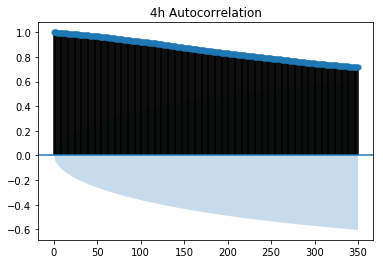

In [8]:
# Plot autocorrelation of close price
# Sample 2015-2018, significance is 400 periods (c. 2 months)
# Sample 2016-2018, significance is 400 periods (c. 2 months)
# Sample 2017/2018, significance is 240 periods (c. 1 month)
# Sample 2015, significance is 100 periods (c. 2 weeks)
# Sample 2016, significance is 160 periods (c. 3 weeks)
# Sample 2017, significance is 140 periods (c. 3 weeks)
# Sample partial-2018, significance is 50 periods (c. 1 week)

from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
series = df['close']
# plot_acf(series,lags=len(series)-1, alpha=0.05, title='4h Autocorrelation')
plot_acf(series,lags=350, alpha=0.05, title='4h Autocorrelation')
plt.show();

Price is not random. There are emerging trends over time. The time series is autocorrelated for c. 2 months.

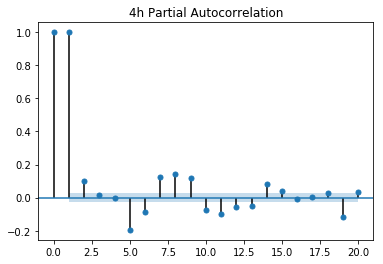

In [9]:
# Plot partial autocorrelation - close price 
# Sample 2017/2018, significance is 2 periods (8 hours)
# Sample 2017, significance is 1 periods (8 hours)
# Sample partial-2018, significance is 2 periods (8 hours)
from statsmodels.graphics.tsaplots import plot_pacf
series = df['close']
plot_pacf(series, lags=20,alpha=0.05, title='4h Partial Autocorrelation')
plt.show()

On the other hand - prices on shorter time scales are largely random after 8 hours has passed

In [10]:
# How many buy periods were there against sell periods
df['target'].value_counts()

buy     3139
sell    2285
Name: target, dtype: int64

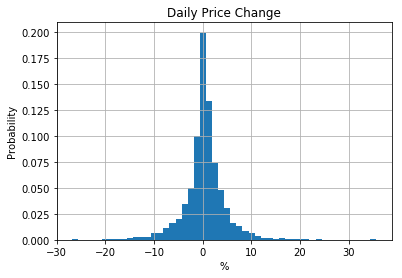

In [11]:
# The spread of daily price changes
x = df['1day_price_change'].dropna()

# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1)

plt.xlabel('%')
plt.ylabel('Probability')
plt.title('Daily Price Change')
plt.grid(True)
plt.show()

In [12]:
# Price change from 24h ago
df['prev_1day_price_change'] = (df['close'].shift(6) - df['close'])/(df['close'].shift(6))*100

In [13]:
# RSI appears too choppy to use meaningfully, hence calculating a moving average 6 period RSI
df['rsi_ma6'] = df['rsi'].rolling(window=6).mean()

In [14]:
# Smooth out volume over the day
df['Volume_BTC_ma6'] = df['Volume_BTC'].rolling(window=6).mean()

In [15]:
# Measure how far the closing price is away from the upper and lower bollinger bands
df['bblower_dist']=(df['close']-df['bblower'])/df['bbwidth']
df['bbupper_dist']=(df['bbupper']-df['close'])/df['bbwidth']

In [16]:
# Create a EMA crossover metric
df['emahist'] = df['ema20'] - df['ema50']

In [17]:
df.dropna(inplace=True)
print(df.shape)
df.head()

(5375, 25)


,Timestamp,open,high,low,close,Volume_BTC,rsi,bbupper,bbmiddle,bblower,...,ema50,candle_summary,1day_price_change,target,prev_1day_price_change,rsi_ma6,Volume_BTC_ma6,bblower_dist,bbupper_dist,emahist
1530,2016-01-09 04:00:00,415.00,415.00,411.00,414.87,6.710800,55.731622,418.876179,416.460,414.043821,...,404.974000,0,-1.017186,sell,0.824727,59.862088,73.948794,0.170968,0.829032,8.493083
1531,2016-01-09 08:00:00,413.32,415.13,411.31,414.24,68.240101,54.570058,417.574973,415.620,413.665027,...,405.337373,0,-1.680185,sell,1.253874,58.170844,66.849839,0.147054,0.852946,8.203321
1532,2016-01-09 12:00:00,414.11,414.32,411.26,414.00,57.062590,54.107407,417.586502,415.264,412.941498,...,405.677083,0,-1.369565,sell,1.061084,56.722242,58.256132,0.227880,0.772120,7.907354
1533,2016-01-09 16:00:00,413.61,416.44,412.93,414.94,65.949553,55.691876,416.370808,414.848,413.325192,...,406.040335,0,-0.939895,sell,0.202030,56.314027,41.908230,0.530207,0.469793,7.673203
1534,2016-01-09 20:00:00,414.95,414.98,412.39,412.99,30.950000,51.703870,415.622745,414.208,412.793255,...,406.312871,0,0.033899,buy,0.966381,54.990698,42.474457,0.069534,0.930466,7.331759


<b> PLOT INDICATORS

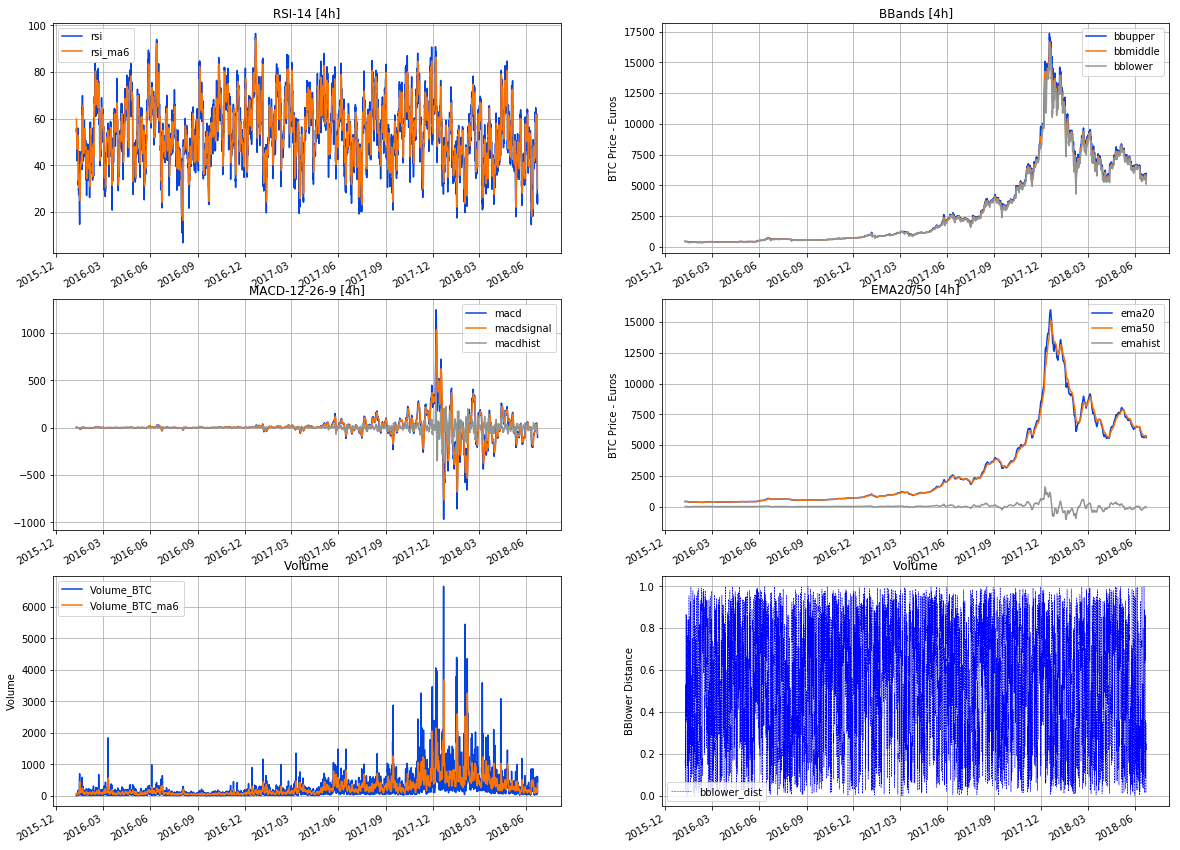

In [18]:
# Plot all results - MAKE SELECTION OF TIMEFRAME

RSI_title = 'RSI-14 [4h]'
BBands_title = 'BBands [4h]'
MACD_title = 'MACD-12-26-9 [4h]'
EMA_title = 'EMA20/50 [4h]'
Vol_title='Volume'
################################################
# Set the color scheme for plots - https://xkcd.com/color/rgb/ (for named colors)
color_list = ["blue","orange", "grey"]
sns.palplot(sns.xkcd_palette(color_list))
color_list_palette = sns.xkcd_palette(color_list)
sns.set_palette(color_list_palette);
%matplotlib inline
################################################
fig, axes = plt.subplots(3,2,figsize=(20,16))
df.plot(x='Timestamp', y='rsi', ax=axes[0][0],grid=True, title=RSI_title);
df.plot(x='Timestamp', y='rsi_ma6', ax=axes[0][0],grid=True, title=RSI_title);
axes[0][0].set_xlabel("")

df.plot(x='Timestamp', y='bbupper',ax=axes[0][1],grid=True, title=BBands_title)
df.plot(x='Timestamp', y='bbmiddle',ax=axes[0][1],grid=True)
df.plot(x='Timestamp', y='bblower',ax=axes[0][1],grid=True)
axes[0][1].set_ylabel("BTC Price - Euros")
axes[0][1].set_xlabel("")

df.plot(x='Timestamp', y='macd',ax=axes[1][0],grid=True, title=MACD_title)
df.plot(x='Timestamp', y='macdsignal',ax=axes[1][0],grid=True)
df.plot(x='Timestamp', y='macdhist',ax=axes[1][0],grid=True)
axes[1][0].set_xlabel("")

df.plot(x='Timestamp', y='ema20',ax=axes[1][1],grid=True, title=EMA_title)
df.plot(x='Timestamp', y='ema50',ax=axes[1][1],grid=True)
df.plot(x='Timestamp', y='emahist',ax=axes[1][1],grid=True)
axes[1][1].set_xlabel("")
axes[1][1].set_ylabel("BTC Price - Euros");

#df.plot(kind=bar,x='Timestamp', y='Volume_BTC',ax=axes[2][0],grid=True, title=Vol_title)
df.plot(x='Timestamp', y='Volume_BTC', ax=axes[2][0], grid=True,title=Vol_title)
df.plot(x='Timestamp', y='Volume_BTC_ma6', ax=axes[2][0], grid=True,title=Vol_title)
axes[2][0].set_xlabel("")
axes[2][0].set_ylabel("Volume");

#df.plot(kind=bar,x='Timestamp', y='Volume_BTC',ax=axes[2][0],grid=True, title=Vol_title)
df.plot(x='Timestamp', y='bblower_dist', ax=axes[2][1], grid=True,title=Vol_title, style='b--', lw=0.5)
axes[2][1].set_xlabel("")
axes[2][1].set_ylabel("BBlower Distance");

# 2.1 Time Series Prediction

In [19]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y/%m/%d %H:%M")
df.index = df['Timestamp']

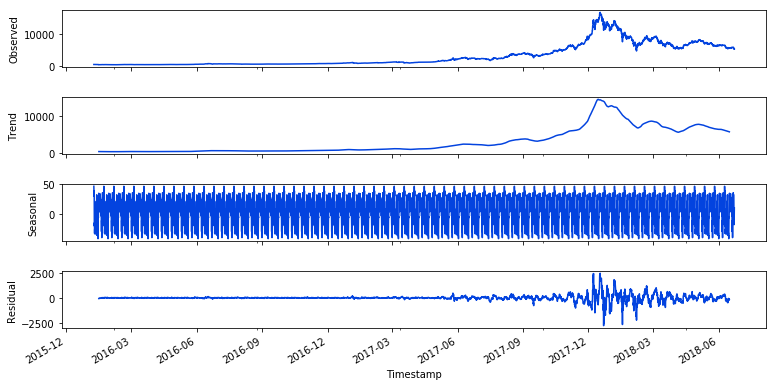

In [20]:
# Set the frequency of the model to be about a week
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['close'], freq=84)
fig = decomposition.plot()
fig.set_size_inches(12, 6)

plt.show()

In [21]:
print(df['close'].index.min(), df['close'].index.max())

2016-01-09 04:00:00 2018-06-23 00:00:00


In [22]:
# let's use "up to Feb 2018" as the training set and the rest as test, so we incorporate one Christmas forecast
train = df['close'][:"2018-04-30"]
test = df['close']["2018-05-01":]
print(len(train), len(test))

5056 319


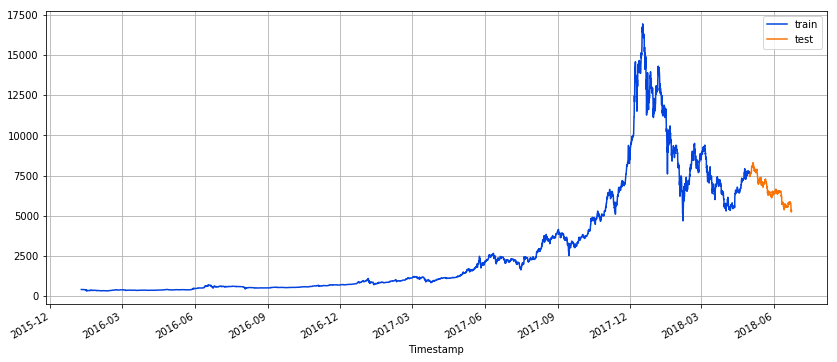

In [34]:
fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test", grid=True)
ax.legend()

plt.show()

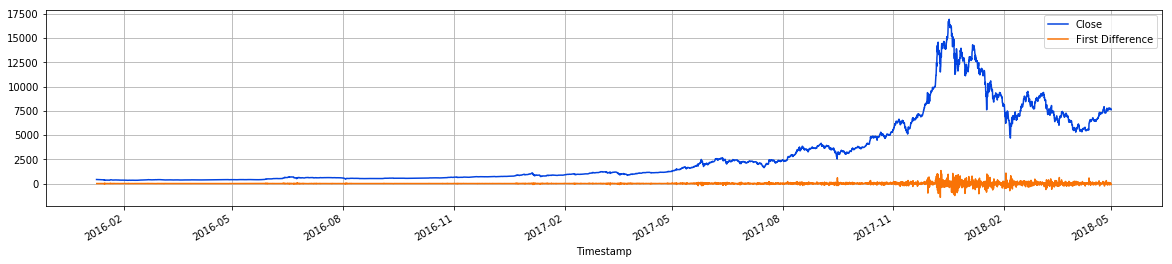

In [23]:
# Check for stationarity
first_diff = train.diff(periods = 1)

fig, ax = plt.subplots(figsize=(20, 4))
train.plot(label="Close")
first_diff.plot(label="First Difference", grid=True)
ax.legend()
plt.show()

In [24]:
# Check for stationarity
first_diff_clean = first_diff.dropna()
from statsmodels.tsa.stattools import adfuller

adfuller(first_diff_clean)

(-12.58162814770368,
 1.9048301822284568e-23,
 31,
 5023,
 {'1%': -3.431652537323488,
  '10%': -2.5670763824860745,
  '5%': -2.8621155812282546},
 62138.22405103589)

In [25]:
import statsmodels as sm                                          # sm.__version__
from statsmodels.tsa.arima_model import ARIMA
import datetime

In [26]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=7607.351106, expected=7490.010000
predicted=7516.072937, expected=7456.950000
predicted=7483.197794, expected=7499.980000
predicted=7480.699730, expected=7432.580000
predicted=7404.118974, expected=7491.990000
predicted=7473.938176, expected=7534.990000
predicted=7554.793258, expected=7524.970000
predicted=7546.265049, expected=7628.130000
predicted=7642.173093, expected=7625.500000
predicted=7637.660881, expected=7599.940000
predicted=7594.531964, expected=7615.070000
predicted=7615.558843, expected=7699.990000
predicted=7683.123995, expected=7693.020000
predicted=7683.572213, expected=7680.350000
predicted=7687.844682, expected=7689.990000
predicted=7714.867144, expected=7874.930000
predicted=7863.353203, expected=8035.260000
predicted=8010.653618, expected=8068.120000
predicted=8066.369945, expected=8013.010000
predicted=8064.362600, expected=8081.010000
predicted=8119.922840, expected=8100.020000
predicted=8094.192729, expected=8103.080000
predicted=8056.160795, expected=

predicted=6379.177101, expected=6460.580000
predicted=6423.226144, expected=6464.900000
predicted=6439.968962, expected=6379.980000
predicted=6411.509967, expected=6355.060000
predicted=6400.094717, expected=6440.010000
predicted=6448.512734, expected=6429.560000
predicted=6404.750323, expected=6549.990000
predicted=6510.079057, expected=6587.080000
predicted=6593.523912, expected=6570.000000
predicted=6594.880628, expected=6577.030000
predicted=6615.739338, expected=6572.990000
predicted=6586.142959, expected=6560.000000
predicted=6539.062486, expected=6643.530000
predicted=6606.287106, expected=6631.450000
predicted=6619.640184, expected=6642.490000
predicted=6651.078108, expected=6618.000000
predicted=6656.034380, expected=6624.560000
predicted=6640.067379, expected=6594.580000
predicted=6592.412150, expected=6514.810000
predicted=6501.589050, expected=6510.010000
predicted=6494.967343, expected=6409.490000
predicted=6411.595829, expected=6408.710000
predicted=6401.506765, expected=

In [27]:
# Accuracy check
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
print ('As % of mean:', rmse/test.mean()*100)

Test RMSE: 81.953
As % of mean: 1.2281050817222428


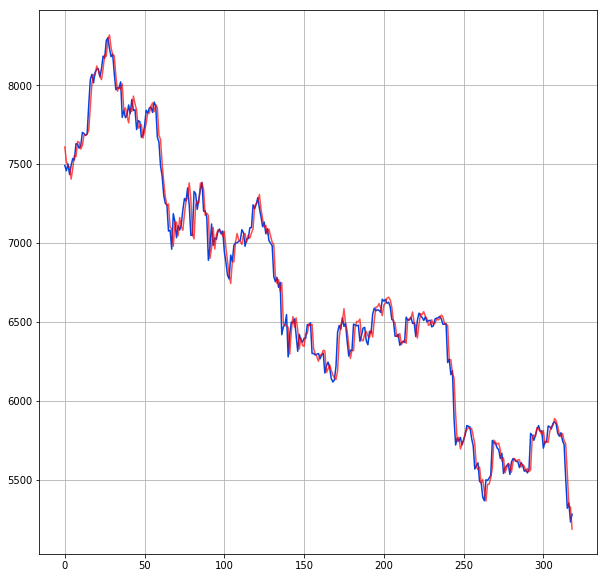

In [44]:
from matplotlib import pyplot
plt.figure(figsize=(10,10))
pyplot.plot(test.tolist())
pyplot.plot(predictions, color='red', alpha=0.7)
pyplot.grid()
pyplot.show()

In [28]:
predictions_series = pd.Series([i for x in predictions for i in x], index=test.index)

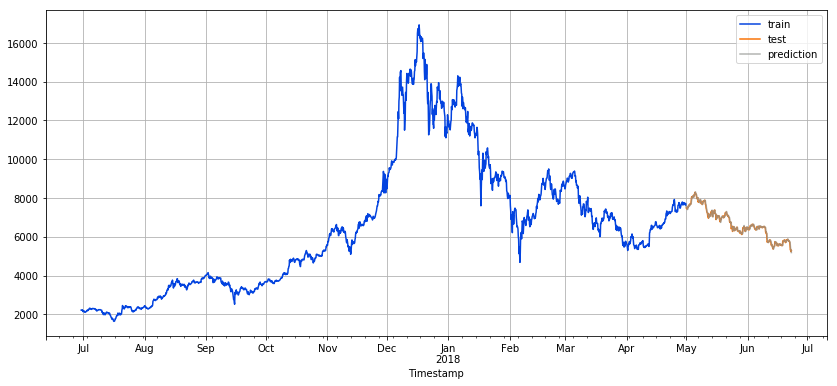

In [47]:
fig, ax = plt.subplots(figsize=(14, 6))

df['close']["2017-06-30":"2018-04-30"].plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
predictions_series.plot(ax=ax, label="prediction", alpha=0.7)
pyplot.grid()
ax.legend()

plt.show()